In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Load Dataset
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# 2. Select Features
# Removing 'Channel' and 'Region' to focus on spending behavior
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features]

# 3. Standardize the Data
# Crucial for distance-based algorithms like K-Means and Hierarchical
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data loaded and scaled successfully.")
print(f"Shape: {X_scaled.shape}")

Data loaded and scaled successfully.
Shape: (440, 6)


Optimal number of clusters (k) based on Silhouette Score: 3


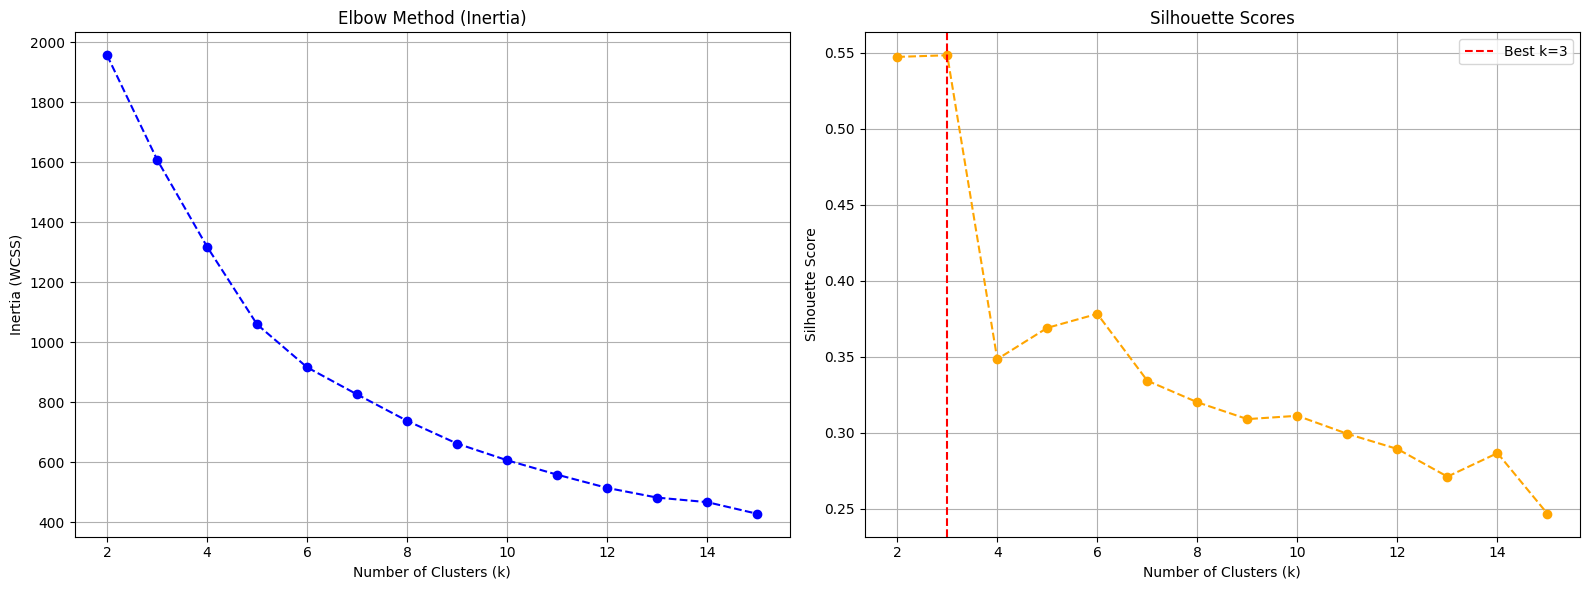

In [2]:
inertia = []
silhouette_scores = []
K_range = range(2, 16)

# Calculate metrics for each k
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

# Identify optimal k automatically (based on max Silhouette Score)
best_k_idx = np.argmax(silhouette_scores)
optimal_k = K_range[best_k_idx]

print(f"Optimal number of clusters (k) based on Silhouette Score: {optimal_k}")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Plot
ax[0].plot(K_range, inertia, marker='o', linestyle='--', color='blue')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia (WCSS)')
ax[0].grid(True)

# Silhouette Plot
ax[1].plot(K_range, silhouette_scores, marker='o', linestyle='--', color='orange')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Best k={optimal_k}')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

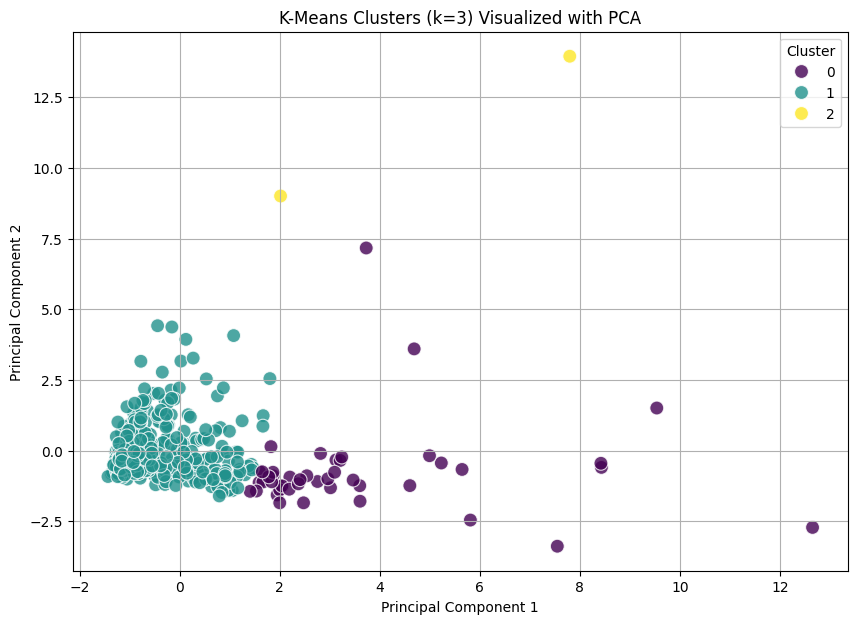

In [3]:
# 1. Fit K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

# 2. PCA for Visualization (Reduce 6 dimensions to 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Plot Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='viridis', s=100, alpha=0.8)
plt.title(f'K-Means Clusters (k={optimal_k}) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

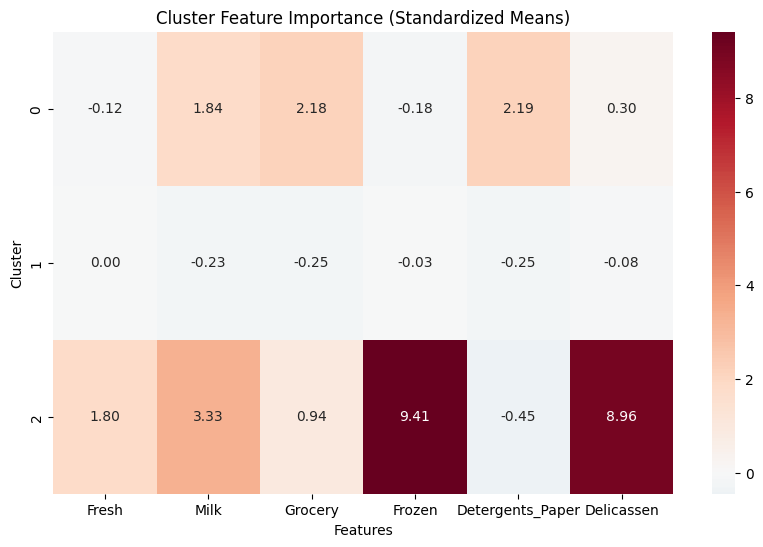


Average Spending (Monetary Units) per Cluster:
                   Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Cluster_KMeans                                                             
0               10440.93  19386.42  28656.09   2190.24          13327.80   
1               12062.91   4115.10   5534.97   2940.68           1696.17   
2               34782.00  30367.00  16898.00  48701.50            755.50   

                Delicassen  
Cluster_KMeans              
0                  2374.20  
1                  1299.11  
2                 26776.00  


In [4]:
# Create a DataFrame for the scaled data to calculate means
df_scaled_vis = pd.DataFrame(X_scaled, columns=features)
df_scaled_vis['Cluster'] = labels_kmeans

# Calculate the mean of each feature for each cluster
cluster_means = df_scaled_vis.groupby('Cluster').mean()

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title(f'Cluster Feature Importance (Standardized Means)')
plt.ylabel('Cluster')
plt.xlabel('Features')
plt.show()

# Show actual monetary averages (unscaled)
df['Cluster_KMeans'] = labels_kmeans
print("\nAverage Spending (Monetary Units) per Cluster:")
print(df.groupby('Cluster_KMeans')[features].mean().round(2))

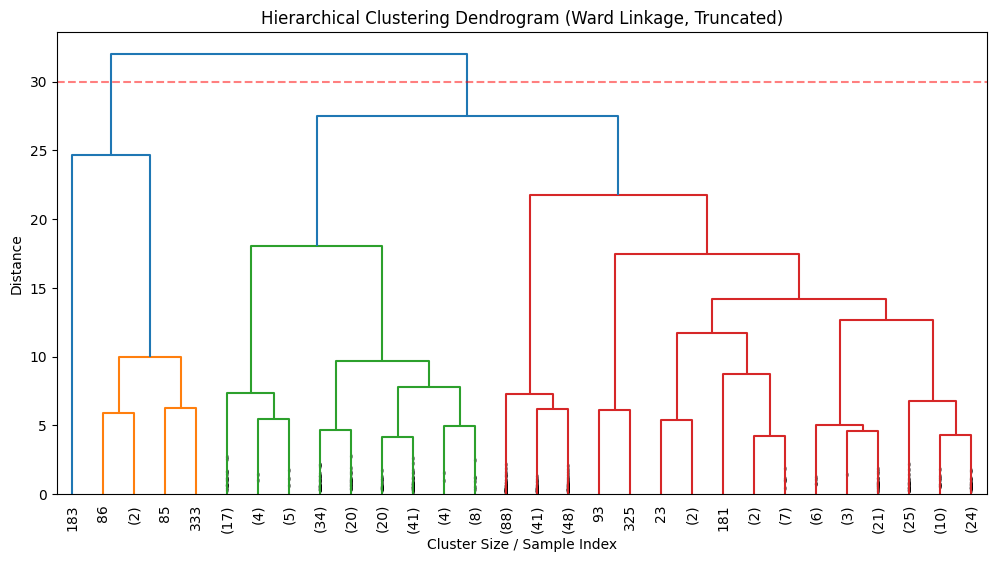

In [5]:
# Calculate Linkage Matrix (Ward's method)
Z = linkage(X_scaled, method='ward')

# Plot Dendrogram (Truncated for readability)
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage, Truncated)')
plt.xlabel('Cluster Size / Sample Index')
plt.ylabel('Distance')
plt.axhline(y=30, color='r', linestyle='--', alpha=0.5) # Optional visual guide
plt.show()

In [6]:
# Fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_agg = agg_clustering.fit_predict(X_scaled)

# Add to main DataFrame
df['Cluster_Agg'] = labels_agg

# Compare the size of clusters between the two methods
print("Cluster Counts (K-Means):")
print(df['Cluster_KMeans'].value_counts().sort_index())

print("\nCluster Counts (Agglomerative):")
print(df['Cluster_Agg'].value_counts().sort_index())

Cluster Counts (K-Means):
Cluster_KMeans
0     45
1    393
2      2
Name: count, dtype: int64

Cluster Counts (Agglomerative):
Cluster_Agg
0      6
1    281
2    153
Name: count, dtype: int64
